# Generative Adversarial Networks (GANs)

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes "fake" data to pass to the discriminator. The discriminator also sees real training data and predicts if the data it's received is real or fake. 
* The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data. 
* The discriminator is a classifier that is trained to figure out which data is real and which is fake. 

What ends up happening is that the generator learns to make data that is indistinguishable from real data to the discriminator.

In [4]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [5]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


# Visualize the Data

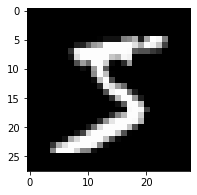

In [17]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

# Discriminator (D)

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define all layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, output_size)
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 784)
        # pass x through all layers
        # apply leaky relu activation to all hidden layers
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Generator (G)



In [19]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define all layers
        self.fc1 = nn.Linear(input_size, hidden_dim*2)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc3 = nn.Linear(hidden_dim*4, output_size)
        

    def forward(self, x):
        # pass x through all layers
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        # final layer should have tanh applied
        x = F.tanh(self.fc3(x))
        return x

# Hyperparameters

In [20]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 28*28
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of *last* hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 28*28
# Size of *first* hidden layer in the generator
g_hidden_size = 32

In [21]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

Generator(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=784, bias=True)
)


# Discriminator and Generator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 

> * The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [22]:
# Calculate losses
def real_loss(D_out, smooth=False):
    # compare logits to real labels
    # smooth labels if smooth=True
    batch_size = D_out.shape[0]
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    # compare logits to fake labels
    batch_size = D_out.shape[0]
    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

# Optimizers

In [23]:
import torch.optim as optim

# learning rate for optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr=lr)
g_optimizer = optim.Adam(G.parameters(), lr=lr)

---
# Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

In [24]:
import pickle as pkl

# training hyperparams
num_epochs = 40

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        d_optimizer.zero_grad()
        # 1. Train with real images
        d_out = D(real_images)

        # Compute the discriminator losses on real images
        # use smoothed labels
        d_real_loss = real_loss(d_out)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images
        d_out = D(fake_images)
        d_fake_loss = fake_loss(d_out)
        
        # add up real and fake losses and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        d_out = D(fake_images)
        
        # perform backprop
        g_loss = real_loss(d_out)
        g_loss.backward()
        g_optimizer.step()
        

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode
d_fake_loss = real_loss

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   40] | d_loss: 1.3525 | g_loss: 0.7599
Epoch [    1/   40] | d_loss: 10.0462 | g_loss: 0.6110
Epoch [    1/   40] | d_loss: 1.8892 | g_loss: 0.5256
Epoch [    2/   40] | d_loss: 0.7782 | g_loss: 1.3627
Epoch [    2/   40] | d_loss: 1.3986 | g_loss: 0.7347
Epoch [    2/   40] | d_loss: 0.0623 | g_loss: 5.7711
Epoch [    3/   40] | d_loss: 0.0310 | g_loss: 17.7921
Epoch [    3/   40] | d_loss: 0.1266 | g_loss: 15.7190
Epoch [    3/   40] | d_loss: 0.2254 | g_loss: 13.8325
Epoch [    4/   40] | d_loss: 0.5273 | g_loss: 12.4419
Epoch [    4/   40] | d_loss: 2.7110 | g_loss: 0.7216
Epoch [    4/   40] | d_loss: 5.8626 | g_loss: 14.3020
Epoch [    5/   40] | d_loss: 0.1344 | g_loss: 6.6598
Epoch [    5/   40] | d_loss: 2.4978 | g_loss: 3.2505
Epoch [    5/   40] | d_loss: 1.6012 | g_loss: 11.8132
Epoch [    6/   40] | d_loss: 4.8198 | g_loss: 7.5017
Epoch [    6/   40] | d_loss: 0.2912 | g_loss: 20.9612
Epoch [    6/   40] | d_loss: 1.1160 | g_loss: 4.9558
Epoch [    7/   40] 

# Training Loss


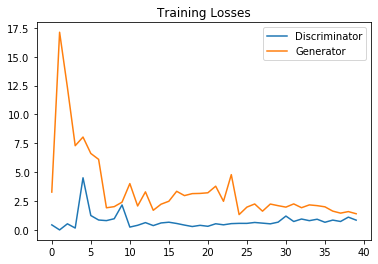

In [25]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

# Generate Samples from Training


In [26]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

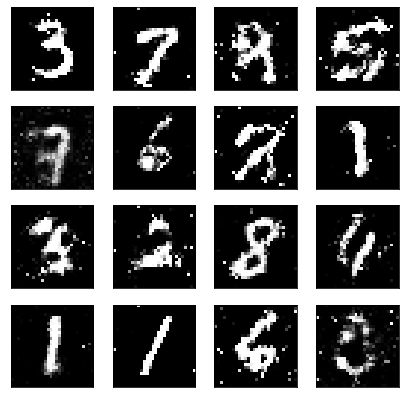

In [28]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

# Sample new images from Generator

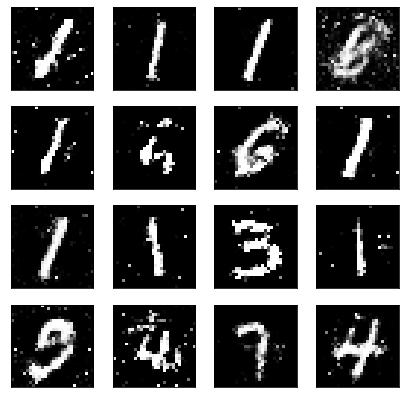

In [29]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])